# Cardiotocography (CTG) Workshop


pip install pandas seaborn scikit-learn scipy imbalanced-learn

In [ ]:
%pip install pandas seaborn scikit-learn scipy imbalanced-learn xlrd

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)
Note: you may need to restart the kernel to use updated packages.


## Workbook Structure


We now reference `ctg.xlsx`, which contains the exported engineered feature table (formerly Sheet 2). All analysis below reads directly from this file.


Keep the original documentation handy if you want definitions or chi-square context from Sheet 1, but no additional code changes are needed for those references.

In [2]:
# Core libraries
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    warnings.warn("imblearn not available. Install with `pip install imbalanced-learn` to enable SMOTE demos.")

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

## Workbook Structure
The Excel workbook `CTG 2.xls` contains three sheets:
1. **Sheet 1** – documentation with clinical definitions and chi-square statistics.
2. **Sheet 2** – engineered features per exam segment plus labels (focus for ML).
3. **Sheet 3** – raw readings with redundant label encodings.

We'll focus on Sheet 2 for modeling, using Sheet 1 & 3 for reference when needed.

## Clinical context
Understanding the fetal physiology behind each feature keeps the analytics grounded:
- **Baseline FHR (`LB`)**: Normal 110–160 bpm; <110 suggests bradycardia and possible hypoxia, >160 suggests tachycardia (infection, maternal fever).
- **Accelerations (`AC`)**: Short spikes in FHR that reassure clinicians the autonomic system is responsive. Their absence alongside other issues is worrisome.
- **Variability metrics (`mSTV`, `ASTV`, `mLTV`, `ALTV`)**: Represent beat-to-beat and minute-level wiggle in the trace. Low variability is one of the earliest hypoxia clues.
- **Decelerations (`DL`, `DS`, `DP`, `DR`)**: Drops in FHR. Shape and timing differentiate benign early decels from late or prolonged decels that hint at placental insufficiency or cord compression.
- **Histogram descriptors (e.g., `Mean`, `Mode`, `Variance`, `Tendency`)**: Summaries of the CTG signal distribution; flattened histograms mirror clinically "flat" traces.
- **Labels (`NSP`)**: Mirror bedside triage: 1 = reassuring/normal, 2 = suspicious, 3 = pathological. False negatives (predicting 1 when the trace is truly 3) are the riskiest errors.
Keep these heuristics handy while interpreting every plot or model score that follows.

In [25]:
ctg_path = Path("CTG.xlsx")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path}"


def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    if isinstance(sheet, int):
        sheet_name = xls.sheet_names[sheet]
    else:
        sheet_name = sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df



sheet2_raw = read_feature_sheet(ctg_path, sheet=1)


print("Sheets detected:", pd.ExcelFile(ctg_path).sheet_names)
print("Feature sheet shape:", sheet2_raw.shape)

Sheets detected: ['Description', 'Data', 'Raw Data']
Feature sheet shape: (2129, 46)


In [26]:
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    """Drop blank columns/rows, clean names, and deduplicate headers."""
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned


sheet2 = tidy_sheet(sheet2_raw)


target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
label_leak_cols = [col for col in label_leak_cols if col in sheet2.columns]


sheet2.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,9.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2.00,1.00


## Dataset Familiarization
We'll focus on Sheet 2 to build supervised models later. Let's examine basic properties.

In [28]:
sheet2_shape = sheet2.shape
sheet2_info = sheet2.info()
sheet2.describe(include='all').T.head(42)

<class 'pandas.core.frame.DataFrame'>
Index: 2128 entries, 0 to 2128
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2127 non-null   float64
 4   UC        2127 non-null   float64
 5   DL        2128 non-null   float64
 6   DS        2128 non-null   float64
 7   DP        2128 non-null   float64
 8   DR        2128 non-null   float64
 9   LB        2126 non-null   float64
 10  AC.1      2126 non-null   float64
 11  FM.1      2127 non-null   float64
 12  UC.1      2127 non-null   float64
 13  DL.1      2128 non-null   float64
 14  DS.1      2128 non-null   float64
 15  DP.1      2128 non-null   float64
 16  ASTV      2127 non-null   float64
 17  mSTV      2127 non-null   float64
 18  ALTV      2127 non-null   float64
 19  mLTV      2127 non-null   float64
 20  Width     2126 non-null   float64
 

,count,mean,std,min,25%,50%,75%,max
b,"2,126.00",878.44,894.08,0.00,55.00,538.00,"1,521.00","3,296.00"
e,"2,126.00","1,702.88",930.92,287.00,"1,009.00","1,241.00","2,434.75","3,599.00"
AC,"2,126.00",2.72,3.56,0.00,0.00,1.00,4.00,26.00
FM,"2,127.00",7.50,39.03,0.00,0.00,0.00,2.00,564.00
UC,"2,127.00",3.67,2.88,0.00,1.00,3.00,5.00,23.00
DL,"2,128.00",1.58,2.52,0.00,0.00,0.00,3.00,16.00
DS,"2,128.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
DP,"2,128.00",0.13,0.47,0.00,0.00,0.00,0.00,4.00
DR,"2,128.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
LB,"2,126.00",133.30,9.84,106.00,126.00,133.00,140.00,160.00


### Target Variable: NSP
- **1** → Normal
- **2** → Suspect
- **3** → Pathologic

We'll profile imbalance and set expectations for modeling.

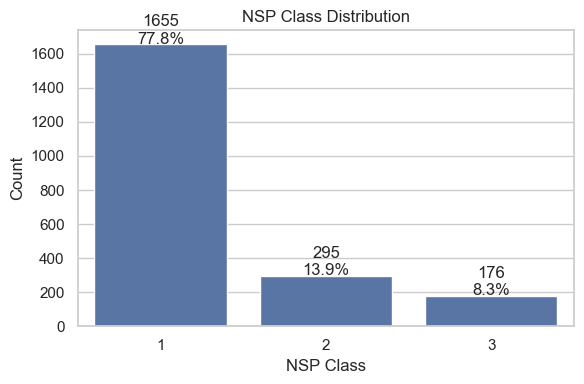

,Class,Count,Proportion
0,1,1655,0.78
1,2,295,0.14
2,3,176,0.08


In [29]:
class_counts = sheet2[target_col].value_counts().sort_index()
class_props = class_counts / class_counts.sum()


fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(int), y=class_counts.values, ax=ax)
ax.set_xlabel('NSP Class')
ax.set_ylabel('Count')
ax.set_title('NSP Class Distribution')
for index, value in enumerate(class_counts.values):
    label = f"{value}\n{class_props.iloc[index]:.1%}"
    ax.text(index, value + 5, label, ha='center')
plt.tight_layout()
plt.show()


pd.DataFrame({
    'Class': class_counts.index.astype(int),
    'Count': class_counts.values,
    'Proportion': class_props.values
})

## Feature Overview
We'll organize Sheet 2 features into clinically meaningful groups. Which family do you expect to be most predictive?

- **Physiological signals:** AC, FM, UC, DL, DS, DP.
- **Variability metrics:** ASTV, mSTV, ALTV, mLTV.
- **Histogram descriptors:** Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency.
- **Timing:** b (start), e (end).
- **Baseline references:** LBE (expert), LB (SisPorto).

### Feature Interpretations 

**Baseline Features**:
- **LB**: Fetal heart rate baseline (bpm) - Normal: 110-160 bpm
- **AC**: Accelerations (signs of fetal well-being)
- **FM**: Fetal movements

**Variability Measures** (critical for fetal health):
- **ASTV**: % time with abnormal short-term variability
- **ALTV**: % time with abnormal long-term variability
- Low variability (<10) may indicate fetal distress

**Deceleration Features** (warning signs):
- **DL**: Light decelerations
- **DS**: Severe decelerations (≥1 is concerning)
- **DP**: Prolonged decelerations


In [57]:
feature_groups = {
    'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
    'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
    'histogram': ['Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency'],
    'timing': ['b', 'e'],
    'baseline': ['LBE', 'LB']
}

available_features = {group: [col for col in cols if col in sheet2.columns]
                      for group, cols in feature_groups.items()}
available_features

{'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
 'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
 'histogram': ['Width',
  'Min',
  'Max',
  'Nmax',
  'Nzeros',
  'Mode',
  'Mean',
  'Median',
  'Variance',
  'Tendency'],
 'timing': ['b', 'e'],
 'baseline': ['LB']}

---
# Data Cleaning
We'll address missing values, outliers, duplicates, and leakage before deeper exploration.

## Missing Values
1. Check for nulls.
2. Demonstrate median imputation by masking a subset of values.
3. Decide whether to drop or impute actual missing data (if any).

In [31]:
missing_summary = sheet2.isna().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

b           2
Width       2
CLASS       2
Tendency    2
Variance    2
Median      2
Mean        2
Mode        2
Nzeros      2
Nmax        2
Max         2
e           2
Min         2
NSP         2
AC          2
AC.1        2
LB          2
LD          1
D           1
C           1
B           1
A           1
FM          1
UC          1
DE          1
SUSP        1
FS          1
AD          1
FM.1        1
UC.1        1
mLTV        1
ALTV        1
mSTV        1
ASTV        1
E           1
dtype: int64

In [ ]:
missing_rows = sheet2[sheet2.isnull().any(axis=1)]
missing_rows.head()


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
2127,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,NaN,...,53.00,81.00,72.00,332.00,252.00,107.00,69.00,197.00,NaN,NaN
2128,NaN,NaN,NaN,564.00,23.00,16.00,1.00,4.00,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop rows with missing columns


In [85]:
clean_df = clean_df.drop(missing_rows.index)
clean_df.shape
missing_summary = clean_df.isna().sum().sort_values(ascending=False)
missing_summary

KeyError: '[2127, 2128] not found in axis'

*Decision:* keep real missingness minimal by imputing medians for continuous signals if/when discovered. Document any imputed columns in future modeling steps.

### Outlier spotlight
- Watch the left tails of `ASTV` and `ALTV`. Clinically, prolonged periods with <10% variability line up with the "flat trace" obstetricians fear.
- The `DP` spikes (prolonged decels) are rare but critical. In labour, these long drops coupled with slow recovery can signal cord compression.
- High `MSTV` or `Variance` usually correspond to an active, well-oxygenated fetus. Do not over-clean them away—they are reassuring physiology.

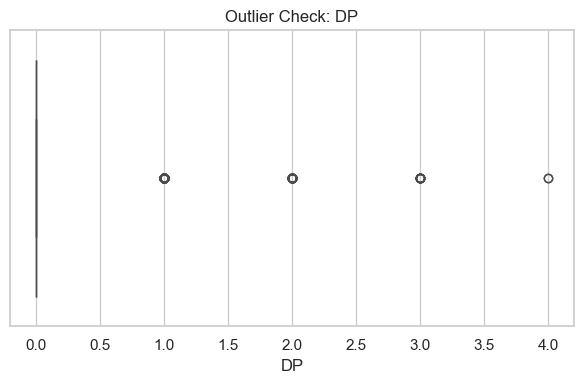

,DP,NSP
5,2.00,3.00
6,2.00,3.00
20,3.00,3.00
22,2.00,3.00
662,2.00,2.00


In [33]:
outlier_feature = 'DP' if 'DP' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

dp_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(dp_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

In [34]:
sheet2[outlier_feature].value_counts().head()

DP
0.00    1949
1.00     109
2.00      49
3.00      19
4.00       2
Name: count, dtype: int64

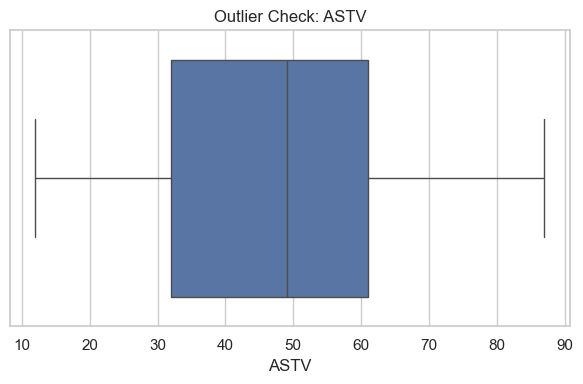

,ASTV,NSP


In [ ]:
outlier_feature = 'ASTV' if 'ASTV' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

astv_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(astv_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

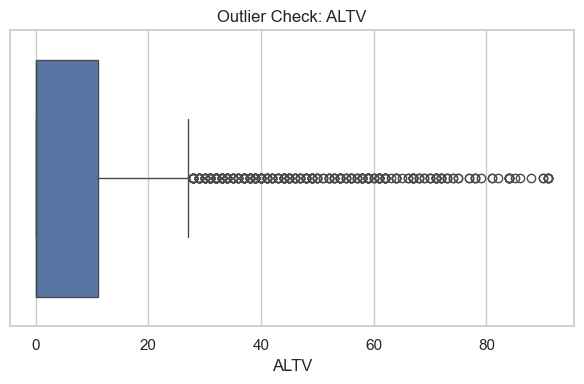

,ALTV,NSP
24,79.00,3.00
25,72.00,3.00
27,71.00,3.00
54,69.00,3.00
91,67.00,2.00


In [36]:
outlier_feature = 'ALTV' if 'ALTV' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

astv_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(astv_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

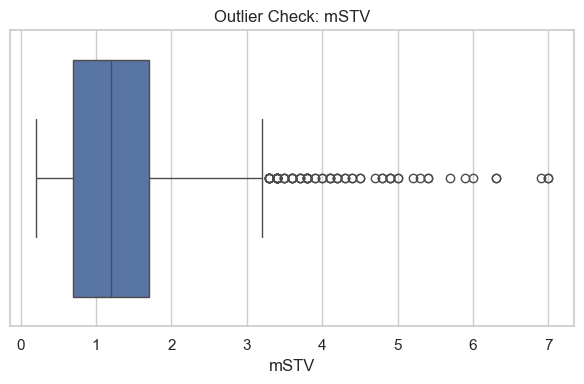

,mSTV,NSP
5,5.90,3.00
6,6.30,3.00
28,4.40,2.00
29,6.00,1.00
30,4.50,1.00


In [38]:
outlier_feature = 'mSTV' if 'mSTV' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

astv_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(astv_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

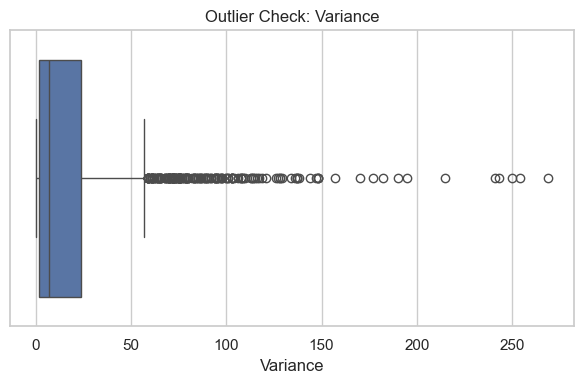

,Variance,NSP
5,170.00,3.00
6,215.00,3.00
20,138.00,3.00
22,148.00,3.00
52,108.00,2.00


In [39]:
outlier_feature = 'Variance' if 'Variance' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

astv_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(astv_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

**Discussion prompt:** Do we cap extreme decelerations, treat them as clinically significant signals, or pursue robust models (e.g., tree ensembles) that tolerate skew?

## Duplicates & Redundant Labels
Sheet 3 contains redundant one-hot encodings (A–SUSP) and `CLASS`, which directly map to NSP. We'll remove them to avoid leakage.

In [40]:
duplicate_rows = sheet2.duplicated().sum()
duplicate_rows

10

In [41]:
columns_to_drop = label_leak_cols
print('Dropping label leakage columns:', columns_to_drop)
clean_df = sheet2.drop(columns=columns_to_drop, errors='ignore')
clean_df.head()

Dropping label leakage columns: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00,1.00


---
# Exploration
We now analyze central tendencies, distributions, and relationships to NSP.

### Predictive Indicator Distribution
Let's look at the sample distribution for key predictive indicators of pathology such as extreme LB or low variability.

In [66]:
anomalous_records = clean_df[
    (clean_df['LB'] > 160) | 
    (clean_df['LB'] < 110) | 
    (clean_df['ASTV'] < 10) | 
    (clean_df['DS'] >= 1) 
].copy()

# Add column indicating which conditions are met
anomalous_records['Anomaly_Reason'] = anomalous_records.apply(
    lambda row: ', '.join(filter(None, [
        'LB>160' if row['LB'] > 160 else '',
        'LB<110' if row['LB'] < 110 else '',
        'ASTV<10' if row['ASTV'] < 10 else '',
        'DS≥1' if row['DS'] >= 1 else '',
    ])),
    axis=1
)

print(f"Total Anomalous Records: {len(anomalous_records)} ({len(anomalous_records)/len(clean_df)*100:.1f}%)")
print("\nBreakdown by condition:")
print(f"  LB > 160:    {(clean_df['LB'] > 160).sum()}")
print(f"  LB < 110:    {(clean_df['LB'] < 110).sum()}")
print(f"  ASTV < 10:   {(clean_df['ASTV'] < 10).sum()}")
print(f"  DS >= 1:     {(clean_df['DS'] >= 1).sum()}")

print("\nNSP Distribution in Anomalous Records:")
print(anomalous_records['NSP'].value_counts().sort_index())

# Display sample
print("\nSample Anomalous Records:")
print(anomalous_records[['LB', 'ASTV', 'DS', 'NSP', 'Anomaly_Reason']].head(10))

Total Anomalous Records: 15 (0.7%)

Breakdown by condition:
  LB > 160:    0
  LB < 110:    7
  ASTV < 10:   0
  DS >= 1:     8

NSP Distribution in Anomalous Records:
NSP
1.00    8
3.00    6
Name: count, dtype: int64

Sample Anomalous Records:
         LB  ASTV   DS  NSP Anomaly_Reason
1488 132.00 31.00 1.00 1.00           DS≥1
1489 132.00 32.00 1.00 3.00           DS≥1
1659 106.00 62.00 0.00 1.00         LB<110
1660 106.00 63.00 0.00 1.00         LB<110
1661 106.00 63.00 0.00 1.00         LB<110
1662 106.00 63.00 0.00 1.00         LB<110
1663 106.00 63.00 0.00 1.00         LB<110
1664 106.00 64.00 0.00 1.00         LB<110
1665 106.00 64.00 0.00 1.00         LB<110
1791 121.00 66.00 1.00 3.00           DS≥1


## Descriptive Statistics
Let's compare Normal vs Pathologic segments for key features like AC (accelerations) and DL (light decelerations).

In [42]:
stats_cols = [col for col in ['AC', 'DL'] if col in clean_df.columns]
group_summary = clean_df.groupby(target_col)[stats_cols].agg(['median', 'mean']).round(2)
group_summary

AC          DL     
     median mean median mean
NSP                         
1.00   2.00 3.42   0.00 1.61
2.00   0.00 0.21   0.00 0.40
3.00   0.00 0.33   2.00 3.15

In [43]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
b,"2,126.00",878.44,894.08,0.00,55.00,538.00,"1,521.00","3,296.00"
e,"2,126.00","1,702.88",930.92,287.00,"1,009.00","1,241.00","2,434.75","3,599.00"
AC,"2,126.00",2.72,3.56,0.00,0.00,1.00,4.00,26.00
FM,"2,127.00",7.50,39.03,0.00,0.00,0.00,2.00,564.00
UC,"2,127.00",3.67,2.88,0.00,1.00,3.00,5.00,23.00
DL,"2,128.00",1.58,2.52,0.00,0.00,0.00,3.00,16.00
DS,"2,128.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
DP,"2,128.00",0.13,0.47,0.00,0.00,0.00,0.00,4.00
DR,"2,128.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
LB,"2,126.00",133.30,9.84,106.00,126.00,133.00,140.00,160.00


In [117]:
if {'LB', 'ASTV'}.issubset(clean_df.columns):
    baseline_bins = pd.cut(clean_df['LB'], bins=[0, 110, 160, np.inf],
                          labels=['Bradycardic', 'Normal baseline', 'Tachycardic'])
    variability_alert = pd.cut(clean_df['ASTV'], bins=[0, 10, 25, np.inf],
                               labels=['<10% (worrisome)', '10-25% (borderline)', '>25% (reassuring)'])
    baseline_ct = pd.crosstab(baseline_bins, clean_df[target_col])
    variability_ct = pd.crosstab(variability_alert, clean_df[target_col])
    display(baseline_ct)
    display(variability_ct)
else:
    print('Baseline or ASTV columns missing from clean_df.')

NSP,1.00,2.00,3.00
LB,,,
Bradycardic,22,0,6
Normal baseline,1633,295,170


NSP,1.00,2.00,3.00
ASTV,,,
10-25% (borderline),294,5,2
>25% (reassuring),1361,290,174


### Clinical takeaways from baseline & variability tables
- Most recordings sit in the 110–160 bpm band, and those are predominantly normal (`NSP=1`).
- Every time baseline dips <110 bpm the risk jumps: the small bradycardic group already contains a quarter pathological traces.
- Variability below 10% almost disappears from the dataset because obstetricians intervene early—if you encounter it live, escalate immediately.

## Distribution Plots
Short-term variability (mSTV) typically drops for pathologic cases. We'll visualize mSTV and mLTV histograms by NSP class.

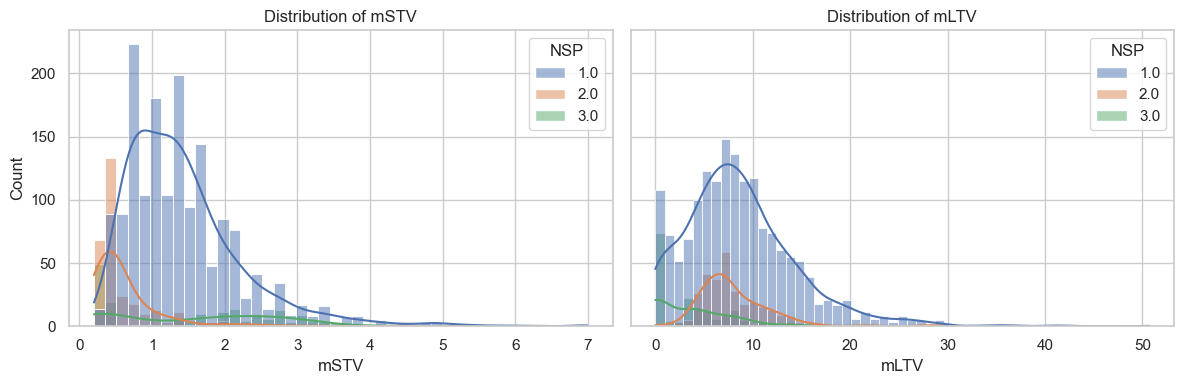

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, feature in zip(axes, ['mSTV', 'mLTV']):
    if feature not in clean_df.columns:
        ax.set_visible(False)
        continue
    sns.histplot(data=clean_df, x=feature, hue=target_col, kde=True,
                 common_norm=False, ax=ax, palette='deep')
    ax.set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

## Boxplots by Class
Visualize decelerations across NSP classes to highlight the severity in pathologic cases.

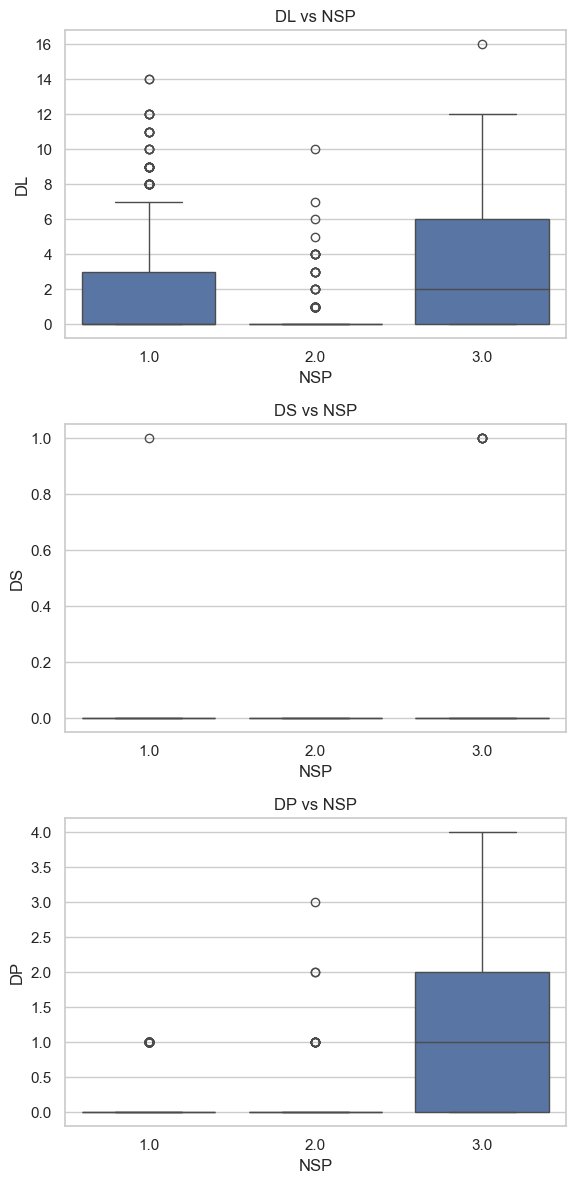

In [46]:
box_features = [col for col in ['DL', 'DS', 'DP'] if col in clean_df.columns]
plt.figure(figsize=(6, 4 * len(box_features)))
for idx, feature in enumerate(box_features, start=1):
    ax = plt.subplot(len(box_features), 1, idx)
    sns.boxplot(data=clean_df, x=target_col, y=feature, ax=ax)
    ax.set_title(f'{feature} vs NSP')
plt.tight_layout()
plt.show()

### Reading the stats with a clinical lens
- **`DP` prolonged decelerations**: The sharp χ² jump warns us that rare, long-lasting decels almost exclusively happen in suspicious/pathological traces.
- **`ASTV`/`ALTV` variability**: Very low variability is the hallmark of hypoxia—these metrics dominate the statistical separation.
- **`Width` and histogram spread**: Flat, narrow histograms match the non-reactive strips clinicians call "silent" CTGs.

## Correlation Heatmap
Investigate multicollinearity among histogram features and variability measures.

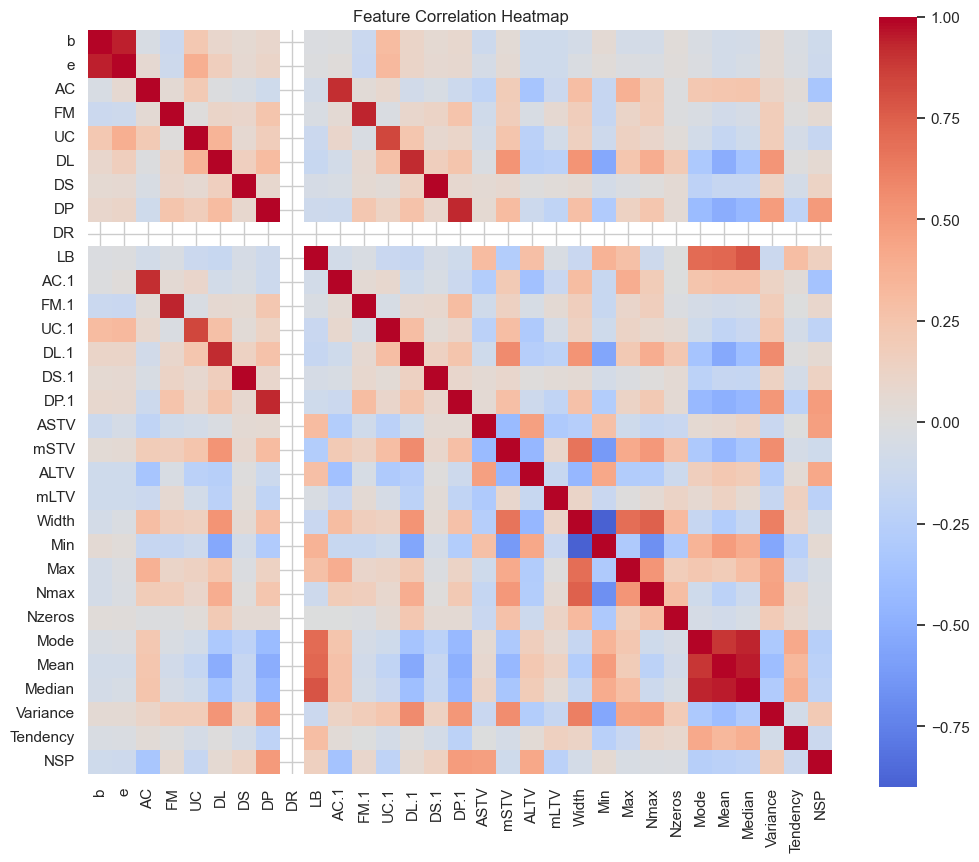

DS     DS.1     0.99
Mean   Median   0.95
b      e        0.94
FM     FM.1     0.94
Mode   Median   0.93
DP     DP.1     0.93
DL     DL.1     0.92
AC     AC.1     0.91
Width  Min      0.90
Mode   Mean     0.89
dtype: float64

In [48]:
corr_features = clean_df.select_dtypes(include=[np.number])
corr_matrix = corr_features.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

corr_pairs = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs.stack().sort_values(ascending=False).head(10)

*Highlight:* Histogram Mean/Median/Mode are strongly collinear - consider pruning for simpler models.

### Heatmap by NSP Class 

Annotated heatmap showing mean feature values by NSP class

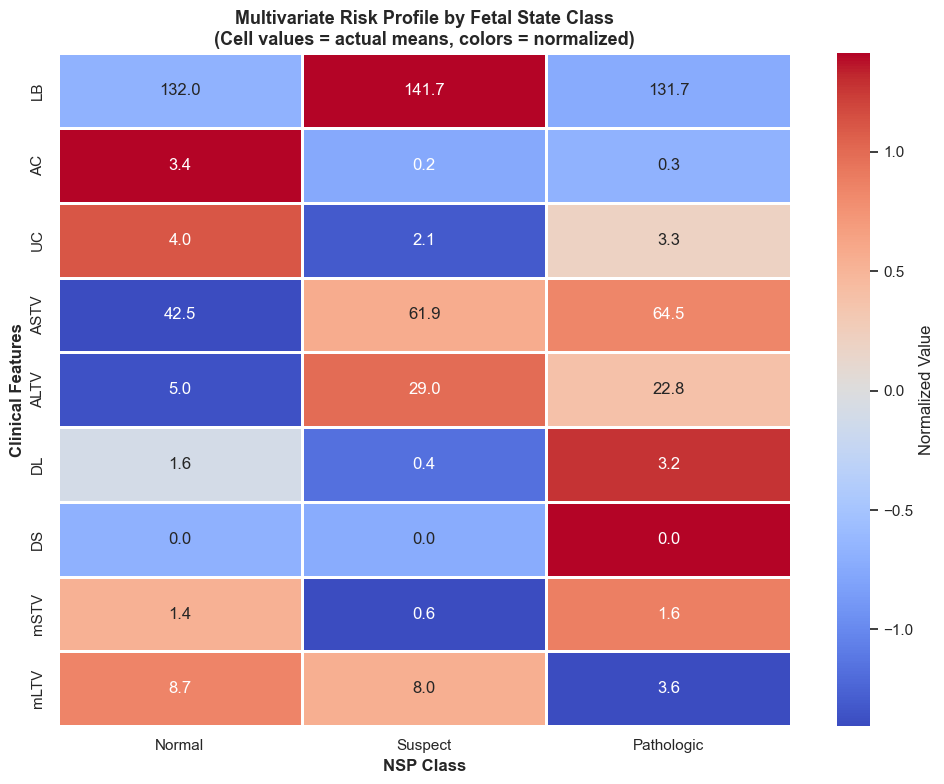

In [71]:
# Select key clinical features
risk_features = ['LB', 'AC', 'UC', 'ASTV', 'ALTV', 'DL', 'DS', 'mSTV', 'mLTV']

# Calculate mean values by NSP class
risk_profile = clean_df.groupby('NSP')[risk_features].mean().T

# Normalize for better visualization (z-scores)
from scipy.stats import zscore
risk_profile_norm = risk_profile.apply(zscore, axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(risk_profile_norm, 
            annot=risk_profile.values,  # Show actual values
            fmt='.1f',
            cmap='coolwarm',  # Red = high risk
            cbar_kws={'label': 'Normalized Value'},
            linewidths=1,
            linecolor='white')

plt.xlabel('NSP Class', fontsize=12, fontweight='bold')
plt.ylabel('Clinical Features', fontsize=12, fontweight='bold')
plt.title('Multivariate Risk Profile by Fetal State Class\n(Cell values = actual means, colors = normalized)', 
          fontsize=13, fontweight='bold')
plt.xticks([0.5, 1.5, 2.5], ['Normal', 'Suspect', 'Pathologic'], rotation=0)
plt.tight_layout()
plt.show()

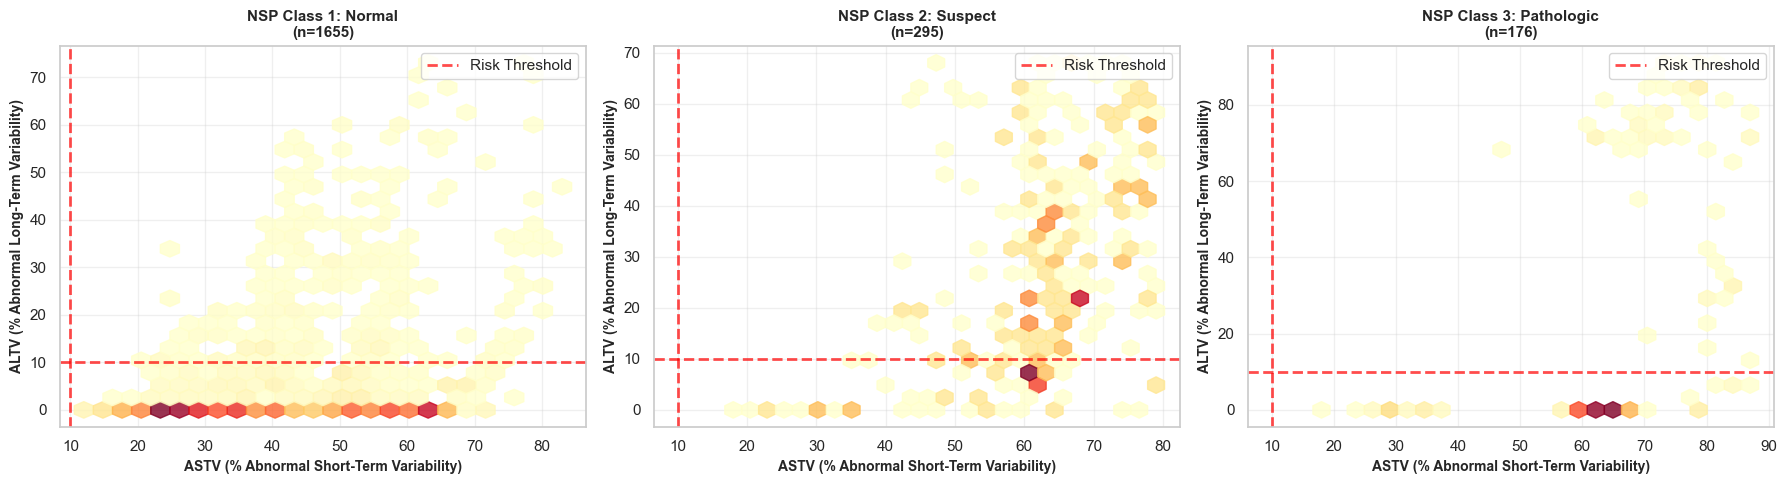

Variability Analysis by NSP:

NSP 1:
  ASTV: mean=42.5, median=41.0
  ALTV: mean=5.0, median=0.0
  Both ASTV<10 AND ALTV<10: 0 cases

NSP 2:
  ASTV: mean=61.9, median=63.0
  ALTV: mean=29.0, median=27.0
  Both ASTV<10 AND ALTV<10: 0 cases

NSP 3:
  ASTV: mean=64.5, median=65.0
  ALTV: mean=22.8, median=0.0
  Both ASTV<10 AND ALTV<10: 0 cases


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create joint plot for each NSP class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, nsp_val in enumerate([1, 2, 3]):
    subset = clean_df[clean_df['NSP'] == nsp_val]
    
    axes[idx].hexbin(subset['ASTV'], subset['ALTV'], 
                     gridsize=25, cmap='YlOrRd', mincnt=1, alpha=0.8)
    
    # Add threshold lines
    axes[idx].axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Risk Threshold')
    axes[idx].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    axes[idx].set_xlabel('ASTV (% Abnormal Short-Term Variability)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('ALTV (% Abnormal Long-Term Variability)', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'NSP Class {nsp_val}: {["Normal", "Suspect", "Pathologic"][nsp_val-1]}\n(n={len(subset)})', 
                       fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Add statistical comparison
print("Variability Analysis by NSP:")
for nsp in [1, 2, 3]:
    subset = clean_df[clean_df['NSP'] == nsp]
    print(f"\nNSP {nsp}:")
    print(f"  ASTV: mean={subset['ASTV'].mean():.1f}, median={subset['ASTV'].median():.1f}")
    print(f"  ALTV: mean={subset['ALTV'].mean():.1f}, median={subset['ALTV'].median():.1f}")
    print(f"  Both ASTV<10 AND ALTV<10: {((subset['ASTV']<10) & (subset['ALTV']<10)).sum()} cases")

/var/folders/_w/nj0j39ld1zq52d4jt7pktc9w0000gn/T/ipykernel_91985/1677114179.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(decel_data, labels=['Normal', 'Suspect', 'Pathologic'],


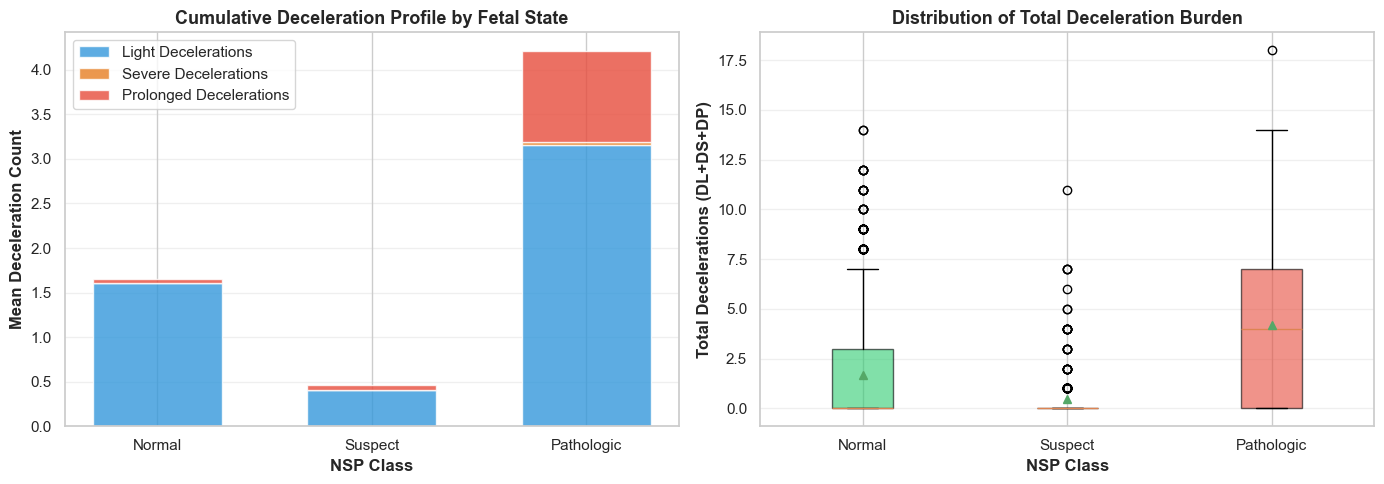

Deceleration Statistics:

NSP 1: mean=1.65, max=14.0, % with DS≥1: 0.1%

NSP 2: mean=0.47, max=11.0, % with DS≥1: 0.0%

NSP 3: mean=4.21, max=18.0, % with DS≥1: 3.4%


In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate deceleration profiles
decel_profile = clean_df.groupby('NSP')[['DL', 'DS', 'DP']].mean()

# Create stacked bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Stacked bar
x_pos = np.arange(len(decel_profile))
width = 0.6

ax1.bar(x_pos, decel_profile['DL'], width, label='Light Decelerations', color='#3498db', alpha=0.8)
ax1.bar(x_pos, decel_profile['DS'], width, bottom=decel_profile['DL'], 
        label='Severe Decelerations', color='#e67e22', alpha=0.8)
ax1.bar(x_pos, decel_profile['DP'], width, 
        bottom=decel_profile['DL'] + decel_profile['DS'], 
        label='Prolonged Decelerations', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('NSP Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean Deceleration Count', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative Deceleration Profile by Fetal State', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Normal', 'Suspect', 'Pathologic'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Right: Box plots for distribution
decel_data = [clean_df[clean_df['NSP']==i][['DL', 'DS', 'DP']].sum(axis=1) for i in [1,2,3]]
bp = ax2.boxplot(decel_data, labels=['Normal', 'Suspect', 'Pathologic'],
                 patch_artist=True, showmeans=True)

for patch, color in zip(bp['boxes'], ['#2ecc71', '#f39c12', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Total Decelerations (DL+DS+DP)', fontsize=12, fontweight='bold')
ax2.set_xlabel('NSP Class', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Total Deceleration Burden', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical summary
print("Deceleration Statistics:")
for nsp in [1, 2, 3]:
    subset = clean_df[clean_df['NSP'] == nsp]
    total_decel = subset['DL'] + subset['DS'] + subset['DP']
    print(f"\nNSP {nsp}: mean={total_decel.mean():.2f}, max={total_decel.max()}, "
          f"% with DS≥1: {(subset['DS']>=1).sum()/len(subset)*100:.1f}%")

## Feature–Target Relationship (ANOVA/Kruskal)
We'll run a Kruskal–Wallis test (non-parametric) across NSP classes for each feature—mirroring the chi-square importance listed in Sheet 1.

In [49]:
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# filter out columns with zero or near-zero variance
non_constant_cols = corr_features.columns[corr_features.nunique() > 1]
corr_features = corr_features[non_constant_cols]

anova_results = []
for feature in corr_features.columns:
    groups = [vals.dropna().values for _, vals in clean_df.groupby(target_col)[feature]]
    if len([g for g in groups if len(g) > 0]) < 2:
        continue
    try:
        h_stat, p_value = stats.kruskal(*groups)
        anova_results.append((feature, h_stat, p_value))
    except ValueError:
        # handles any remaining pathological cases
        continue

anova_df = (pd.DataFrame(anova_results, columns=['Feature', 'H-statistic', 'p-value'])
              .sort_values('H-statistic', ascending=False))
anova_df.head(10)

,Feature,H-statistic,p-value
14,DP.1,541.94,0.00
7,DP,538.48,0.00
15,ASTV,533.44,0.00
17,ALTV,496.07,0.00
9,AC.1,452.92,0.00
2,AC,450.98,0.00
16,mSTV,383.31,0.00
25,Mean,302.79,0.00
26,Median,293.63,0.00
24,Mode,268.72,0.00


*Result:* AC, AS/ALTV, and DP emerge as top discriminators.

---
# Feature Engineering
We'll prep data for modeling: encoding, scaling, imbalance handling, and feature selection.

## Encoding & Leakage Removal
Target `NSP` is already numeric. Redundant dummy columns were dropped earlier. We'll persist `clean_df` as the working table.

In [50]:
# 1. Inspect the target column
clean_df[target_col].value_counts(dropna=False)
clean_df[target_col].unique()

# 2. Drop or impute missing labels
y = clean_df[target_col]

# Option A – drop rows with missing NSP values
mask = y.notna()
y = y.loc[mask]

# Optionally keep the aligned feature matrix if needed later
# X = clean_df.loc[mask, feature_cols]

# 3. Make sure the dtype is consistent (integers)
y = y.astype(int)

# 4. Recompute classes and weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=y)

class_weight_dict = dict(zip(classes, weights))
class_weight_dict


{1: 0.4281973816717019, 2: 2.4022598870056497, 3: 4.026515151515151}

## Scaling Demo
Compare raw vs standardized values for accelerations (AC) and variability (ASTV).

In [51]:
scale_features = [col for col in ['AC', 'ASTV'] if col in clean_df.columns]
scale_sample = clean_df[scale_features].sample(n=5, random_state=0)
scaler = StandardScaler()
scaled_values = scaler.fit_transform(scale_sample)
scaled_df = pd.DataFrame(scaled_values, columns=[f'{col}_scaled' for col in scale_features], index=scale_sample.index)
pd.concat([scale_sample, scaled_df], axis=1)

,AC,ASTV,AC_scaled,ASTV_scaled
563,1.00,30.00,-0.56,-1.52
759,0.00,66.00,-1.12,1.08
1668,3.00,63.00,0.56,0.87
847,1.00,40.00,-0.56,-0.80
1784,5.00,56.00,1.68,0.36


## Handling Imbalance
Suspect cases are underrepresented. We'll compute class weights and demonstrate SMOTE oversampling (when available).

In [52]:
feature_cols = [col for col in clean_df.columns if col != target_col]
y = clean_df[target_col].dropna().astype(int)
X = clean_df.loc[y.index, feature_cols]

# Median-impute any residual NaNs so SMOTE has a dense matrix to work with
X_imputed = X.fillna(X.median(numeric_only=True))

if SMOTE is not None:
    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    X_resampled, y_resampled = smote.fit_resample(X_imputed, y)
    print('Original shape:', X.shape, y.value_counts().to_dict())
    print('Resampled shape:', X_resampled.shape, pd.Series(y_resampled).value_counts().to_dict())
else:
    print('SMOTE unavailable. Consider installing imbalanced-learn for oversampling demos.')

Original shape: (2126, 30) {1: 1655, 2: 295, 3: 176}
Resampled shape: (4965, 30) {2: 1655, 1: 1655, 3: 1655}


## Feature Selection
We'll run filter (chi²), wrapper (placeholder for RFE), and embedded (tree) strategies—starting with chi² via `SelectKBest`.

In [53]:
mask = clean_df[target_col].notna()
y = clean_df.loc[mask, target_col].astype(int)
numeric_features = clean_df.select_dtypes(include=[np.number]).columns.drop(target_col)
X_numeric = clean_df.loc[mask, numeric_features].fillna(clean_df[numeric_features].median())
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X_numeric)
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_scaled, y)
selected_scores = pd.Series(selector.scores_, index=numeric_features).sort_values(ascending=False)
selected_scores.head(15)

DP         306.22
DP.1       282.01
ALTV       196.94
AC.1        80.84
ASTV        58.56
DS          55.31
AC          51.98
DS.1        47.53
Variance    43.87
DL.1        39.10
DL          33.65
Min         29.72
UC.1        23.15
mSTV        21.84
b           19.25
dtype: float64

*Next steps:* For wrappers, try scikit-learn's `RFECV` with a logistic regression baseline. For embedded methods, train a gradient boosting model and inspect feature importances.

---
# Advanced EDA / ML Preparation
PCA, clustering, and stratified splits help validate signal quality before supervised modeling.

## PCA Visualization
Project features into 2D and color by NSP class to gauge separability.

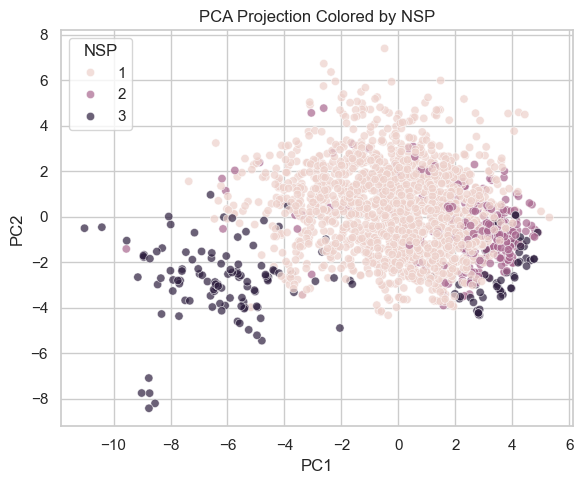

array([0.24173657, 0.13586564])

In [54]:
pca = PCA(n_components=2, random_state=42)
X_scaled_std = StandardScaler().fit_transform(X_numeric)
pca_components = pca.fit_transform(X_scaled_std)
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df[target_col] = y.values

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target_col, alpha=0.7)
plt.title('PCA Projection Colored by NSP')
plt.tight_layout()
plt.show()

pca.explained_variance_ratio_

Normals cluster more tightly; Suspects overlap with both extremes—hinting at classification difficulty.

## Clustering Sanity Check
Use k-means (k=3) to see how unsupervised clusters align with NSP labels.

In [55]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled_std)
cluster_vs_nsp = pd.crosstab(cluster_labels, y, normalize='index').round(2)
cluster_vs_nsp

NSP,1,2,3
row_0,,,
0,0.70,0.24,0.06
1,0.32,0.07,0.62
2,0.97,0.03,0.00


If clusters show high purity for Normal vs Pathologic but mixed Suspect rates, that's a quick signal of borderline cases.

## Train/Test Split
Finalize a modeling-ready dataset with a stratified 70/30 split.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
    'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
    'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
}).rename(columns=lambda c: c if c == 'Split' else f'{c} proportion')

Train shape: (1488, 30)
Test shape: (638, 30)


,Split,Normal (1) proportion,Suspect (2) proportion,Pathologic (3) proportion
0,Train,0.78,0.14,0.08
1,Test,0.78,0.14,0.08


**Takeaway:** Stratification keeps the scarce Suspect cases balanced across splits. Pathologic cases remain easier to separate than borderline suspects—expect this to drive model tuning discussions.

---
## Next Steps
- Prototype baseline classifiers (logistic regression, random forest) using the engineered dataset.
- Evaluate with metrics sensitive to imbalance (balanced accuracy, macro F1).
- Discuss clinical constraints: false negatives on Pathologic cases carry high risk.
- Consider temporal modeling (Sheet 3 raw signals) for future work.